# 内容一：在MNIST数据集上构建网络进行分类

## 1. 实验前导

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torch.utils.data as tud
import numpy as np

## 2. 准备数据

### 学会使用Dataloader来加载数据
Dataloader能够帮我们打乱数据集，拿到batch数据 \
为了使用Dataloader，需要定义以下三个function
- \__init__: 模型初始化
- \__len__: 返回整个数据集有多少item
- \__getitem__: 根据给定的index返回一个item

调用Dataloader之前还要先定义dataset

In [2]:
# Pytorch帮助我们预先加载了一些常用的数据集
# 如果使用这些数据集，会相对容易的进行数据加载
# 例如：常用的Mnist数据集
mnist_train_data = datasets.MNIST("./mnist_data",train=True,download=True,
                                 transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=(0.13066062,),std=(0.30810776,))
                                 ]))
batch_size = 64
train_dataloader = tud.DataLoader(mnist_train_data,batch_size = batch_size,shuffle=True) # 将dataset转换为iterator
mnist_test_data = datasets.MNIST("./mnist_data",train=False,download=True,
                                 transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=(0.13066062,),std=(0.30810776,))
                                 ]))
test_dataloader = tud.DataLoader(mnist_test_data,batch_size = batch_size)

In [3]:
mnist_data = datasets.MNIST("./mnist_data",train=True,download=True)

In [4]:
mnist_data[9][0]

In [5]:
mnist_data = datasets.MNIST("./mnist_data", train=True, download=True,
                           transform = transforms.Compose([
                               transforms.ToTensor()
                           ]))

In [6]:
mnist_data[9][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [7]:
data = [d[0].data.numpy() for d in mnist_data]
np.std(data)

0.30810776

## 3. 配置网络

### (1) 定义网络
- 继承 nn.Module
- 初始化函数
- forward 函数
- 其余可以根据模型需要定义相关的函数

In [8]:
# 定义一个简单的基于ConvNet的简单神经网络
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__() # the input is 1*28*28
        self.conv1 = nn.Conv2d(1,20,5,1) # (28-5)/1+1=24, 20*24*24
        self.conv2 = nn.Conv2d(20,50,5,1) # 12-5+1=8
        self.fc1 = nn.Linear(4*4*50,500)
        self.fc2 = nn.Linear(500,10)
    def forward(self,x):
        x = F.relu(self.conv1(x)) # 20 * 24 * 24
        x = F.max_pool2d(x,2,2) # 20 * 12 * 12
        x = F.relu(self.conv2(x)) # 50 * 8 * 8
        x = F.max_pool2d(x,2,2) # 50 * 4 * 4
        x = x.view(-1,4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x #F.log_softmax(x,dim=1)
model = Net()

### (2) 定义损失函数

In [9]:
loss_fn = nn.CrossEntropyLoss(reduction='mean')

### (3) 定义优化算法

In [10]:
lr = 0.01
momentum = 0.5
optimizer = optim.SGD(model.parameters(),lr=lr,momentum=momentum)

## 4. 训练网络

- 模型一般需要训练若干个epoch
- 每个epoch我们把所有数据分成若干个batch
- 把每个batch的输入和输出都包装成cuda Tensor
- forward pass
- 计算loss
- 清空gradient
- backward pass
- 更新模型参数
- 每隔一定的iteration输出loss，以及在验证集上做模型的评估

In [11]:
def train(model,train_dataloader,loss_fn,optimizer,epoch):
    model.train()
    for idx, (data, label) in enumerate(train_dataloader):
        output = model(data)
        loss = loss_fn(output,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if idx % 100 == 0:
            print("Train Epoch: {}, iteration: {}, loss: {}".format(
                epoch,idx,loss.item()))  
    return model

## 5. 模型评估

In [12]:
def test(model,test_dataloader,loss_fn):
    model.eval()
    total_loss = 0.
    correct = 0.
    with torch.no_grad():
        for idx, (data,target) in enumerate(test_dataloader):
            output = model(data) # batch_size * 10        
            loss = loss_fn(output,target)*output.size(0)
            pred = output.argmax(dim=1)
            total_loss += loss
            correct += pred.eq(target).sum()
    total_loss /= len(test_dataloader.dataset)
    acc = correct/len(test_dataloader.dataset)
    print("Test Loss:{}, Accuracy:{}".format(total_loss,acc))
    return acc

## 6. 模型存储

In [13]:
#torch.save(model.state_dict(),"mnist_cnn.pth")
num_epochs = 2
best_valid_acc = 0.
for epoch in range(num_epochs):
    train(model,train_dataloader,loss_fn,optimizer,epoch)
    acc = test(model,test_dataloader,loss_fn)
    if acc > best_valid_acc:
        best_valid_acc = acc
        torch.save(model.state_dict(),"best_mnist_cnn.pth")

Train Epoch: 0, iteration: 0, loss: 2.2969322204589844
Train Epoch: 0, iteration: 100, loss: 0.4167231619358063
Train Epoch: 0, iteration: 200, loss: 0.29881107807159424
Train Epoch: 0, iteration: 300, loss: 0.33433419466018677
Train Epoch: 0, iteration: 400, loss: 0.24201732873916626
Train Epoch: 0, iteration: 500, loss: 0.1544746309518814
Train Epoch: 0, iteration: 600, loss: 0.07010394334793091
Train Epoch: 0, iteration: 700, loss: 0.16299577057361603
Train Epoch: 0, iteration: 800, loss: 0.06378766149282455
Train Epoch: 0, iteration: 900, loss: 0.302877277135849
Test Loss:0.09049069881439209, Accuracy:0.9729999899864197
Train Epoch: 1, iteration: 0, loss: 0.04969342052936554
Train Epoch: 1, iteration: 100, loss: 0.12178995460271835
Train Epoch: 1, iteration: 200, loss: 0.12363199889659882
Train Epoch: 1, iteration: 300, loss: 0.04517880827188492
Train Epoch: 1, iteration: 400, loss: 0.05274515971541405
Train Epoch: 1, iteration: 500, loss: 0.14362449944019318
Train Epoch: 1, iterat

### Load模型

In [51]:
test_model = Net()
test_model.load_state_dict(torch.load("best_mnist_cnn.pth"))
test(model,test_dataloader,loss_fn)

Test Loss:0.19123974442481995, Accuracy:0.9477124214172363


tensor(0.9477)

### For FashionMNIST

In [15]:
# 在fashionmnist上实现
fashion_train_data = datasets.FashionMNIST("./fashion_mnist_data",train=True,download=True,
                                 transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=(0.2860402,),std=(0.3530239,))
                                 ]))
batch_size = 64
fashion_train_dataloader = tud.DataLoader(fashion_train_data,batch_size = batch_size,shuffle=True) # 将dataset转换为iterator
fashion_test_data = datasets.FashionMNIST("./fashion_mnist_data",train=False,download=True,
                                 transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=(0.28604063,),std=(0.3530239,))
                                 ]))
fashion_test_dataloader = tud.DataLoader(fashion_test_data,batch_size = batch_size)

In [16]:
fashion_model = Net()
fashion_loss_fn = nn.CrossEntropyLoss(reduction='mean')
fashion_optimizer = optim.SGD(fashion_model.parameters(),lr=lr,momentum=momentum)

In [17]:
num_epochs = 2
best_valid_acc = 0.
for epoch in range(num_epochs):
    train(fashion_model,fashion_train_dataloader,fashion_loss_fn,fashion_optimizer,epoch)
    acc = test(fashion_model,fashion_test_dataloader,fashion_loss_fn)
    if acc > best_valid_acc:
        best_valid_acc = acc
        torch.save(fashion_model.state_dict(),"best_fashion_mnist_cnn.pth")

Train Epoch: 0, iteration: 0, loss: 2.3199946880340576
Train Epoch: 0, iteration: 100, loss: 1.1392697095870972
Train Epoch: 0, iteration: 200, loss: 0.8114963173866272
Train Epoch: 0, iteration: 300, loss: 0.8525765538215637
Train Epoch: 0, iteration: 400, loss: 0.6510029435157776
Train Epoch: 0, iteration: 500, loss: 0.5471484661102295
Train Epoch: 0, iteration: 600, loss: 0.8715212345123291
Train Epoch: 0, iteration: 700, loss: 0.7216072678565979
Train Epoch: 0, iteration: 800, loss: 0.5953059792518616
Train Epoch: 0, iteration: 900, loss: 0.45417073369026184
Test Loss:0.5176324248313904, Accuracy:0.8064000010490417
Train Epoch: 1, iteration: 0, loss: 0.47697052359580994
Train Epoch: 1, iteration: 100, loss: 0.46399030089378357
Train Epoch: 1, iteration: 200, loss: 0.4672160744667053
Train Epoch: 1, iteration: 300, loss: 0.5541765093803406
Train Epoch: 1, iteration: 400, loss: 0.476409912109375
Train Epoch: 1, iteration: 500, loss: 0.39205145835876465
Train Epoch: 1, iteration: 600,

In [18]:
fashion_model.load_state_dict(torch.load("best_fashion_mnist_cnn.pth"))
test(fashion_model,fashion_test_dataloader,fashion_loss_fn)

Test Loss:0.41617557406425476, Accuracy:0.8514000177383423


tensor(0.8514)

# 内容二：CNN模型的迁移学习

- 很多时候当我们训练一个新的图像分类任务，我们不会完全从一个随机的模型开始训练，而是利用预训练的模型来加速训练的过程。我们经常使用在ImageNet上的预训练模型
- 有两种方法做迁移学习
    - finetuning：从一个预训练模型开始，改变一些模型的架构，然后继续训练整个模型的参数；
    - feature extraction：不改变预训练模型的参数，只更新我们改变过的部分模型参数。（当成特征提取器来使用）

## 1. 实验前导

In [19]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, datasets, transforms
import torch.utils.data as tud
import numpy as np

## 2. 准备数据

数据：使用hymenoptera_data数据集 \
数据集包括两类图片，bees和ants。这些数据都被处理成了可以使用ImageFolder来读取的格式。我们只需要把data_dir设置成数据的根目录，然后把model_name设置成我们想要使用的预训练模型

In [20]:
# format
data_dir = "./hymenoptera_data"
model_name = "resnet18"
num_class = 2
#feature_extract = True
input_size = 224

读入数据: 把数据预处理成相应的格式

In [21]:
# progress
all_imgs = datasets.ImageFolder(os.path.join(data_dir,"train"),
                                transform=transforms.Compose([
                                    transforms.RandomResizedCrop(input_size),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),                                    
                                ]))
loader = tud.DataLoader(all_imgs,batch_size=batch_size,shuffle=True)

In [22]:
all_imgs[9][0]

tensor([[[0.6235, 0.6196, 0.6157,  ..., 0.6824, 0.6745, 0.6784],
         [0.6078, 0.6039, 0.5961,  ..., 0.6863, 0.6824, 0.6863],
         [0.5725, 0.5686, 0.5686,  ..., 0.6902, 0.6902, 0.6902],
         ...,
         [0.4627, 0.5098, 0.5569,  ..., 0.4431, 0.4706, 0.5020],
         [0.4745, 0.4902, 0.5294,  ..., 0.4980, 0.5137, 0.5490],
         [0.4745, 0.4863, 0.5176,  ..., 0.5137, 0.5412, 0.5647]],

        [[0.4980, 0.4902, 0.4824,  ..., 0.5882, 0.5961, 0.5961],
         [0.4863, 0.4784, 0.4745,  ..., 0.5882, 0.5961, 0.6000],
         [0.4667, 0.4627, 0.4588,  ..., 0.5922, 0.5961, 0.6000],
         ...,
         [0.3569, 0.4000, 0.4667,  ..., 0.3608, 0.4235, 0.4667],
         [0.3569, 0.3804, 0.4235,  ..., 0.4235, 0.4824, 0.5176],
         [0.3451, 0.3765, 0.4118,  ..., 0.4353, 0.4784, 0.5059]],

        [[0.3529, 0.3451, 0.3490,  ..., 0.4784, 0.4784, 0.4863],
         [0.3490, 0.3451, 0.3412,  ..., 0.4706, 0.4706, 0.4902],
         [0.3373, 0.3333, 0.3294,  ..., 0.4745, 0.4745, 0.

In [23]:
# format
batch_size = 32
train_imgs = datasets.ImageFolder(os.path.join(data_dir,"train"),
                                transform=transforms.Compose([
                                    transforms.RandomResizedCrop(input_size),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],[0.229,0.224,0.225])
                                ]))
train_dataloader = tud.DataLoader(train_imgs,batch_size=batch_size,shuffle=True)
test_imgs = datasets.ImageFolder(os.path.join(data_dir,"val"),
                                transform=transforms.Compose([
                                    transforms.Resize(input_size),  
                                    transforms.CenterCrop(input_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],[0.229,0.224,0.225])
                                ]))
test_dataloader = tud.DataLoader(test_imgs,batch_size=batch_size)

## 3. 配置网络

### (1) 定义网络

In [24]:
# format
def initialize_model(model_name,num_class,use_pretrained=True,feature_extract=True):
    if model_name == "resnet18":
        model_ft = models.resnet18(pretrained=use_pretrained)
        if feature_extract: # do not update the parameters
            for param in model_ft.parameters():
                param.requires_grad = False
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_class) # 改变了最后一层，做了个finetune       
    else:
        print("model not implemented")
        return None
    return model_ft
model_ft = initialize_model("resnet18",2,use_pretrained=True,feature_extract=True)

E:\Anaconda\envs\deepl\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\Anaconda\envs\deepl\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
print(model_ft.layer1[0].conv1.weight.requires_grad)
print(model_ft.fc.weight.requires_grad)

False
True


### (2) 定义损失函数

In [27]:
loss_fn = nn.CrossEntropyLoss()

### (3) 定义优化算法

In [28]:
lr = 0.01
momentum = 0.5
optimizer = optim.SGD(model_ft.parameters(),lr=lr,momentum=momentum)

## 4. 训练网络

In [29]:
def train_model(model,train_dataloader,loss_fn,optimizer,epoch):
    model.train()
    total_loss = 0.
    total_corrects = 0.
    for idx, (inputs, labels) in enumerate(train_dataloader):
        outputs = model(inputs)
        loss = loss_fn(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        preds = outputs.argmax(dim=1)
        total_loss += loss.item() * inputs.size(0)
        total_corrects += torch.sum(preds.eq(labels))
    epoch_loss = total_loss / len(train_dataloader.dataset)
    epoch_accuracy = total_corrects / len(train_dataloader.dataset)
    print("Epoch:{}, Training Loss:{}, Traning Acc:{}".format(epoch,epoch_loss,epoch_accuracy))  
    #return model        

## 5. 模型评估

In [30]:
def test_model(model,test_dataloader,loss_fn):
    model.eval()
    total_loss = 0.
    total_corrects = 0.
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test_dataloader):
            outputs = model(inputs)
            loss = loss_fn(outputs,labels)
            preds = outputs.argmax(dim=1)
            total_loss += loss.item() * inputs.size(0)
            total_corrects += torch.sum(preds.eq(labels))
    epoch_loss = total_loss / len(test_dataloader.dataset)
    epoch_accuracy = total_corrects / len(test_dataloader.dataset)
    print("Test Loss:{}, Test Acc:{}".format(epoch_loss,epoch_accuracy))  
    return epoch_accuracy 

In [31]:
num_epochs = 5
test_accuracy_hist = []
for epoch in range(num_epochs):
    train_model(model_ft,train_dataloader,loss_fn,optimizer,epoch)
    acc = test_model(model_ft,test_dataloader,loss_fn)
    test_accuracy_hist.append(acc)

Epoch:0, Training Loss:0.5986682665152628, Traning Acc:0.6762295365333557
Test Loss:0.32767993406532636, Test Acc:0.9019607901573181
Epoch:1, Training Loss:0.35175695477939045, Traning Acc:0.8770492076873779
Test Loss:0.23049903149698295, Test Acc:0.9281045794487
Epoch:2, Training Loss:0.35815655403449886, Traning Acc:0.8483606576919556
Test Loss:0.2904139390957901, Test Acc:0.8823529481887817
Epoch:3, Training Loss:0.2852041384235757, Traning Acc:0.8770492076873779
Test Loss:0.1918486119095796, Test Acc:0.9411764740943909
Epoch:4, Training Loss:0.29034061216917195, Traning Acc:0.8770492076873779
Test Loss:0.2199135523995543, Test Acc:0.9215686321258545


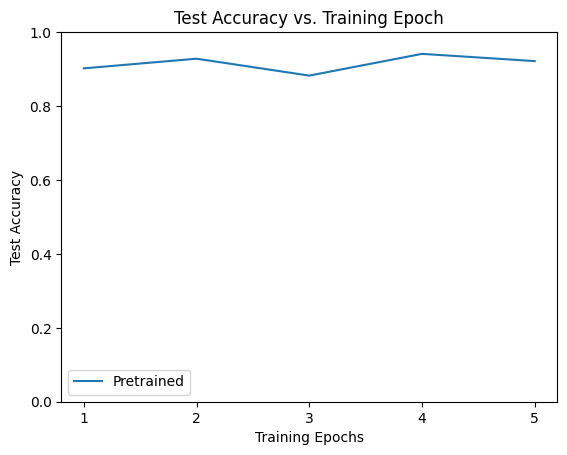

In [32]:
import matplotlib.pyplot as plt
#torch.save(model.state_dict(),"new_cnn.pth")
plt.title("Test Accuracy vs. Training Epoch")
plt.xlabel("Training Epochs")
plt.ylabel("Test Accuracy")
plt.plot(range(1,num_epochs+1),test_accuracy_hist,label="Pretrained")
plt.ylim((0,1.))
plt.xticks(np.arange(1,num_epochs+1,1.0))
plt.legend()
plt.show()

# 作业部分，做一些有意思的工作

### 扩展一、尝试不同的预训练模型
1.1 先查看有哪些模型

In [33]:
# 1. 尝试使用不同的预训练模型，比如VGG，AlexNet
#我们根据内容二代码中的initialize_model函数，可以很容易的使用不同的预训练模型，只需要把model_name改成我们想要使用的模型名字即可


In [34]:
#dir函数可以看到有哪些模型
dir(models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

我们整理内容二的代码，把它变成一个函数，这样我们就可以很方便的使用不同的预训练模型了

In [35]:
# 替换内容二代码中的不同预训练模型
def initialize_model(model_name,num_class,use_pretrained=True,feature_extract=True):
    if model_name == "resnet18":
        model_ft = models.resnet18(pretrained=use_pretrained)
        if feature_extract: # do not update the parameters
            for param in model_ft.parameters():
                param.requires_grad = False
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_class) # 改变了最后一层，做了个finetune       
    elif model_name == "alexnet":
        model_ft = models.alexnet(pretrained=use_pretrained)
        if feature_extract: # do not update the parameters
            for param in model_ft.parameters():
                param.requires_grad = False
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_class) # 改变了最后一层，做了个finetune    
    elif model_name == "vgg11":
        model_ft = models.vgg11(pretrained=use_pretrained)
        if feature_extract: # do not update the parameters
            for param in model_ft.parameters():
                param.requires_grad = False
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_class) # 改变了最后一层，做了个finetune    
    elif model_name == "vgg13":
        model_ft = models.vgg13(pretrained=use_pretrained)
        if feature_extract: # do not update the parameters
            for param in model_ft.parameters():
                param.requires_grad = False
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_class) # 改变了最后一层，做了个finetune    
    elif model_name == "vgg16":
        model_ft = models.vgg16(pretrained=use_pretrained)
        if feature_extract: # do not update the parameters
            for param in model_ft.parameters():
                param.requires_grad = False
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_class) # 改变了最后一层，做了个finetune    
    elif model_name == "vgg19":
        model_ft = models.vgg19(pretrained=use_pretrained)
        if feature_extract: # do not update the parameters
            for param in model_ft.parameters():
                param.requires_grad = False
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_class) # 改变了最后一层，做了个finetune    
    elif model_name == "squeezenet1_0":
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        if feature_extract: # do not update the parameters
            for param in model_ft.parameters():
                param.requires_grad = False
        model_ft.classifier[1] = nn.Conv2d(512,num_class,kernel_size=(1,1),stride=(1,1)) # 改变了最
    elif model_name == "squeezenet1_1":
        model_ft = models.squeezenet1_1(pretrained=use_pretrained)
        if feature_extract: # do not update the parameters
            for param in model_ft.parameters():
                param.requires_grad = False
        model_ft.classifier[1] = nn.Conv2d(512,num_class,kernel_size=(1,1),stride=(1,1)) # 改变了最
    elif model_name == "densenet121":
        model_ft = models.densenet121(pretrained=use_pretrained)
        if feature_extract: # do not update the parameters
            for param in model_ft.parameters():
                param.requires_grad = False        
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs,num_class) # 改变了最后一层，做了个finetune    
    elif model_name == "densenet169":
        model_ft = models.densenet169(pretrained=use_pretrained)
        if feature_extract: # do not update the parameters
            for param in model_ft.parameters():
                param.requires_grad = False        
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs,num_class) # 改变了最后一层，做了个finetune    
    elif model_name == "densenet161":
        model_ft = models.densenet161(pretrained=use_pretrained)
        if feature_extract: # do not update the parameters
            for param in model_ft.parameters():
                param.requires_grad = False        
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs,num_class) # 改变了最后一层，做了个finetune    
    elif model_name == "densenet201":
        model_ft = models.densenet201(pretrained=use_pretrained)
        if feature_extract: # do not update the parameters
            for param in model_ft.parameters():
                param.requires_grad = False        
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs,num_class) # 改变了最后一层，做了个finetune    
    elif model_name == "inception_v3":
        model_ft = models.inception_v3(pretrained=use_pretrained)
        if feature_extract: # do not update the parameters
            for param in model_ft.parameters():
                param.requires_grad = False        
        aux_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(aux_ftrs,num_class)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_class) # 改变了最后一层，做了个finetune    
    elif model_name == "googlenet":
        model_ft = models.googlenet(pretrained=use_pretrained)
        if feature_extract: # do not update the parameters
            for param in model_ft.parameters():
                param.requires_grad = False        
        aux_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(aux_ftrs,num_class)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_class) # 改变了最后一层，做了个finetune    
    elif model_name == "shufflenet_v2_x0_5":
        model_ft = models.shufflenet_v2_x0_5(pretrained=use_pretrained)
        if feature_extract: # do not update the parameters
            for param in model_ft.parameters():
                param.requires_grad = False        
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_class) # 改变了最后一层，做了个finetune    
    elif model_name == "shufflenet_v2_x1_0":
        model_ft = models.shufflenet_v2_x1_0(pretrained=use_pretrained)
        if feature_extract: # do not update the parameters
            for param in model_ft.parameters():
                param.requires_grad = False        
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_class) # 改变了最后一层，
    else:
        print("model not implemented",model_name)
        return None
    return model_ft

In [36]:
#我们依次调用不同模型，看看它们的效果。针对内容二的任务，我们可以使用feature_extract=True，这样我们只更新最后一层的参数，这样可以加快训练速度
# 同时训练不同的预训练模型
model_resnet18 = initialize_model("resnet18",2,use_pretrained=True,feature_extract=True)
model_alexnet = initialize_model("alexnet",2,use_pretrained=True,feature_extract=True)
model_vgg11 = initialize_model("vgg11",2,use_pretrained=True,feature_extract=True)
model_vgg13 = initialize_model("vgg13",2,use_pretrained=True,feature_extract=True)
model_vgg16 = initialize_model("vgg16",2,use_pretrained=True,feature_extract=True)
model_vgg19 = initialize_model("vgg19",2,use_pretrained=True,feature_extract=True)
model_squeezenet1_0 = initialize_model("squeezenet1_0",2,use_pretrained=True,feature_extract=True)
model_squeezenet1_1 = initialize_model("squeezenet1_1",2,use_pretrained=True,feature_extract=True)
model_densenet121 = initialize_model("densenet121",2,use_pretrained=True,feature_extract=True)
model_densenet169 = initialize_model("densenet169",2,use_pretrained=True,feature_extract=True)
model_densenet161 = initialize_model("densenet161",2,use_pretrained=True,feature_extract=True)
model_densenet201 = initialize_model("densenet201",2,use_pretrained=True,feature_extract=True)
model_inception_v3 = initialize_model("inception_v3",2,use_pretrained=True,feature_extract=True)
# model_googlenet = initialize_model("googlenet",2,use_pretrained=True,feature_extract=True)
model_shufflenet_v2_x0_5 = initialize_model("shufflenet_v2_x0_5",2,use_pretrained=True,feature_extract=True)
model_shufflenet_v2_x1_0 = initialize_model("shufflenet_v2_x1_0",2,use_pretrained=True,feature_extract=True)


E:\Anaconda\envs\deepl\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\Anaconda\envs\deepl\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
E:\Anaconda\envs\deepl\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date wei

Training model:ResNet
Epoch:0, Training Loss:0.5825491498728268, Traning Acc:0.7049180269241333
Test Loss:0.31905746800837176, Test Acc:0.915032684803009
Epoch:1, Training Loss:0.3796736641985471, Traning Acc:0.811475396156311
Test Loss:0.49074723440058093, Test Acc:0.7385621070861816
Epoch:2, Training Loss:0.30441520008884493, Traning Acc:0.8770492076873779
Test Loss:0.2427390124283585, Test Acc:0.915032684803009
Epoch:3, Training Loss:0.21625171039925248, Traning Acc:0.9467213153839111
Test Loss:0.20727908883998597, Test Acc:0.9477124214172363
Epoch:4, Training Loss:0.2946857546196609, Traning Acc:0.8729507923126221
Test Loss:0.19059091533710754, Test Acc:0.9411764740943909
Training model:AlexNet
Epoch:0, Training Loss:0.6665136254713183, Traning Acc:0.7418032884597778
Test Loss:0.3856213225258721, Test Acc:0.8888888955116272
Epoch:1, Training Loss:0.29998541098149095, Traning Acc:0.8852459192276001
Test Loss:0.3331909429014119, Test Acc:0.8758170008659363
Epoch:2, Training Loss:0.18

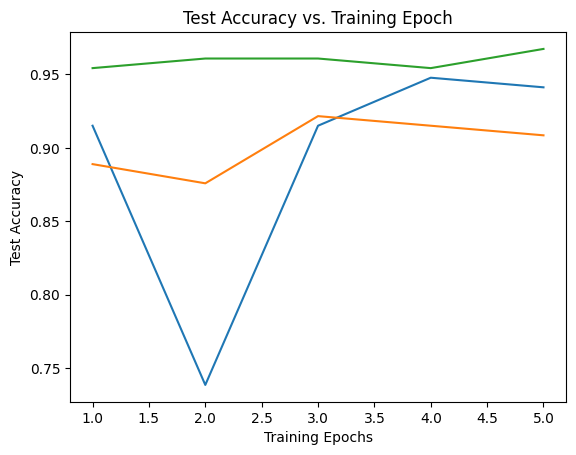

In [37]:
# 我们把所有模型放到一个list里面，方便后面的代码调用
# model_list = [model_resnet18,model_alexnet,model_vgg11,model_vgg13,model_vgg16,model_vgg19,
#               model_squeezenet1_0,model_squeezenet1_1,model_densenet121,model_densenet169,
#               model_densenet161,model_densenet201,model_inception_v3,
#               model_shufflenet_v2_x0_5,model_shufflenet_v2_x1_0]
model_list = [model_resnet18,model_alexnet,model_vgg16]
# 对所有模型依次训练和测试内容二任务，保存每种模型的训练模型和测试效果，方便后面绘图比较
num_epochs = 5
test_accuracy_hist = []
for model in model_list:
    print("Training model:{}".format(model.__class__.__name__))
    optimizer = optim.SGD(model.parameters(),lr=lr,momentum=momentum)
    acc_per_model = []
    for epoch in range(num_epochs):
        train_model(model,train_dataloader,loss_fn,optimizer,epoch)
        acc = test_model(model,test_dataloader,loss_fn)
        acc_per_model.append(acc)
    test_accuracy_hist.append(acc_per_model)
    torch.save(model.state_dict(),"best_{}.pth".format(model.__class__.__name__))
# 绘制不同模型的训练效果对比图
import matplotlib.pyplot as plt
plt.title("Test Accuracy vs. Training Epoch")
plt.xlabel("Training Epochs")
plt.ylabel("Test Accuracy")
for i in range(len(model_list)):
    plt.plot(range(1,num_epochs+1),test_accuracy_hist[i],label=model_list[i].__class__.__name__)

In [38]:
num_epochs = 5
test_accuracy_hist = []
for model in model_list:
    optimizer = optim.SGD(model.parameters(),lr=lr,momentum=momentum)
    test_accuracy_hist.append([])
    for epoch in range(num_epochs):
        train_model(model,train_dataloader,loss_fn,optimizer,epoch)
        acc = test_model(model,test_dataloader,loss_fn)
        test_accuracy_hist[-1].append(acc)
# 绘制图像，查看不同模型在这个任务上经过相同的训练参数得到的效果
import matplotlib.pyplot as plt
plt.title("Test Accuracy vs. Training Epoch")
plt.xlabel("Training Epochs")
plt.ylabel("Test Accuracy")
for i in range(len(model_list)):
    plt.plot(range(1,num_epochs+1),test_accuracy_hist[i],label=model_list[i].__class__.__name__)

Epoch:0, Training Loss:0.29462852536654865, Traning Acc:0.8729507923126221


KeyboardInterrupt: 

### 扩展二、训练模型，来使用自己的图片进行预测
之前所有图片我们只是调用它自己的数据，我们将它应用在自己写的数据集上进行预测。下面的图片是我在平板书书写，截图上传，来查看模型预测结果是否准确

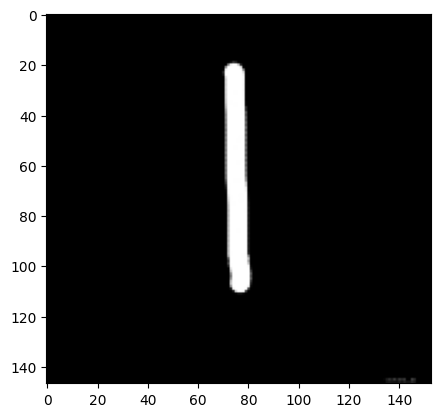

预测结果为： 1


In [49]:
#利用自己的图片进行预测

model = initialize_model("resnet18",2,use_pretrained=True,feature_extract=True)
model.load_state_dict(torch.load("best_ResNet.pth"))

## 读取自己本地图片，预测并输出类别
img = Image.open("./diy/1.jpg")
plt.imshow(img)
plt.show()
#利用模型预测自己的图片
img = transforms.Resize(256)(img)
img = transforms.CenterCrop(224)(img)
img = transforms.ToTensor()(img)
img = transforms.Normalize([0.485, 0.456, 0.406],[0.229,0.224,0.225])(img)
img = img.unsqueeze(0)
output = model(img)
pred = output.argmax(dim=1)
#输出预测结果
print("预测结果为：",pred.item())